# 🔮 PROPHET AUTOMATED TRAINING PIPELINE
## Comprehensive Multi-Resolution Forecasting with Auto-Benchmark

### 🚀 AUTO-RUN CONFIGURATION:
**Just click "Run All" and the notebook will automatically:**
1. Train Prophet models for ALL resolutions (1min, 5min, 15min)
2. Forecast BOTH targets (request_count, total_bytes)
3. Perform hyperparameter tuning for each configuration
4. Generate comprehensive benchmarks
5. Save all predictions and parameters
6. Create comparative visualizations

### 📊 Total Configurations:
- **3 resolutions** × **2 targets** = **6 model trainings**
- Each with hyperparameter tuning
- Expected runtime: **20-40 minutes** (CPU)

### 📁 Output Structure:
```
RESULTS_PROPHET/
├── 1min_request_count/
│   ├── predictions.csv
│   ├── metrics.csv
│   ├── best_parameters.csv
│   └── evaluation.png
├── 1min_total_bytes/
├── 5min_request_count/
├── ... (6 configurations total)
└── FINAL_BENCHMARK/
    ├── comprehensive_comparison.csv
    ├── final_report.txt
    └── benchmark_visualizations.png
```

In [19]:
# ===========================
# CELL 2: SETUP & INSTALLATIONS
# ===========================

!pip install prophet scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
import time
from typing import Dict, List

# Prophet
from prophet import Prophet

# Set seeds
np.random.seed(42)

# Visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 6)

print("="*70)
print("PROPHET AUTOMATED TRAINING PIPELINE")
print("="*70)
print(f"  Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

PROPHET AUTOMATED TRAINING PIPELINE
  Start time: 2026-02-03 02:44:57


In [ ]:
# ===========================
# CELL 3: GLOBAL CONFIGURATION
# ===========================

# Paths
DATA_DIR = 'data'
RESULTS_BASE_DIR = 'models/results_prophet'

# Create base results directory
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)

# All configurations to run
RESOLUTIONS = ['1min', '5min', '15min']
TARGETS = ['request_count', 'total_bytes']

# Hyperparameter search space
PARAM_GRID = {
    'changepoint_prior_scale': [1,5],
    'seasonality_prior_scale': [10, 30],
    'seasonality_mode': ['multiplicative']
}

# Storm/outage holiday (adjust dates if needed)
STORM_HOLIDAY = pd.DataFrame({
    'holiday': 'storm_outage',
    'ds': pd.date_range(start='1995-08-01 14:52:01', end='1995-08-03 04:36:13', freq='h'),
    'lower_window': 0,
    'upper_window': 0,
})

print("\n📋 CONFIGURATION LOADED:")
print(f"  Resolutions: {RESOLUTIONS}")
print(f"  Targets: {TARGETS}")
print(f"  Total configurations: {len(RESOLUTIONS) * len(TARGETS)}")
print(f"  Hyperparameter combinations: {len(PARAM_GRID['changepoint_prior_scale']) * len(PARAM_GRID['seasonality_prior_scale']) * len(PARAM_GRID['seasonality_mode'])}")
print(f"\n  Data directory: {DATA_DIR}")
print(f"  Results directory: {RESULTS_BASE_DIR}")


📋 CONFIGURATION LOADED:
  Resolutions: ['1min', '5min', '15min']
  Targets: ['request_count', 'total_bytes']
  Total configurations: 6
  Hyperparameter combinations: 4

  Data directory: /kaggle/input/preprocess-data
  Results directory: /kaggle/working/


In [21]:
# ===========================
# CELL 4: UTILITY FUNCTIONS
# ===========================

def prepare_prophet_data(df, target_col):
    """
    Prepare data for Prophet.
    """
    prophet_df = pd.DataFrame({
        'ds': df.index,
        'y': df[target_col]
    })
    
    # Add time-based features (always known in future)
    prophet_df['hour'] = prophet_df['ds'].dt.hour
    prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
    prophet_df['is_weekend'] = (prophet_df['day_of_week'] >= 5).astype(int)
    
    return prophet_df


def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # MAPE (avoid division by zero)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else 0
    
    # R²
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }
    
    return metrics


def tune_prophet_hyperparameters(train_data, param_grid, verbose=False):
    """
    Perform grid search for Prophet hyperparameters.
    """
    # Use subset for validation
    val_size = int(len(train_data) * 0.2)
    train_subset = train_data[:-val_size]
    val_subset = train_data[-val_size:]
    
    best_params = None
    best_mae = float('inf')
    results = []
    
    total_combinations = len(param_grid['changepoint_prior_scale']) * \
                        len(param_grid['seasonality_prior_scale']) * \
                        len(param_grid['seasonality_mode'])
    
    if verbose:
        print(f"    Testing {total_combinations} parameter combinations...")
    
    counter = 0
    for cp_scale in param_grid['changepoint_prior_scale']:
        for s_scale in param_grid['seasonality_prior_scale']:
            for s_mode in param_grid['seasonality_mode']:
                counter += 1
                
                try:
                    model = Prophet(
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False,
                        changepoint_prior_scale=cp_scale,
                        seasonality_prior_scale=s_scale,
                        seasonality_mode=s_mode,
                        holidays=STORM_HOLIDAY
                    )
                    
                    model.add_regressor('hour')
                    model.add_regressor('day_of_week')
                    model.add_regressor('is_weekend')
                    
                    model.fit(train_subset)
                    
                    forecast = model.predict(val_subset[['ds', 'hour', 'day_of_week', 'is_weekend']])
                    mae = mean_absolute_error(val_subset['y'], forecast['yhat'])
                    
                    results.append({
                        'changepoint_prior_scale': cp_scale,
                        'seasonality_prior_scale': s_scale,
                        'seasonality_mode': s_mode,
                        'mae': mae
                    })
                    
                    if mae < best_mae:
                        best_mae = mae
                        best_params = {
                            'changepoint_prior_scale': cp_scale,
                            'seasonality_prior_scale': s_scale,
                            'seasonality_mode': s_mode
                        }
                    
                except Exception as e:
                    if verbose:
                        print(f"      Error with params {counter}/{total_combinations}: {str(e)}")
    
    return best_params, best_mae, pd.DataFrame(results)


print("✓ Utility functions defined")

✓ Utility functions defined


In [22]:
# ===========================
# CELL 5: MAIN TRAINING FUNCTION
# ===========================

def train_single_configuration(resolution, target, verbose=True):
    """
    Train a single Prophet model configuration and return results.
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f"TRAINING: Prophet | {resolution} | {target}")
        print(f"{'='*70}")
    
    start_time = time.time()
    
    # Create results directory
    results_dir = f"{RESULTS_BASE_DIR}/{resolution}_{target}"
    os.makedirs(results_dir, exist_ok=True)
    
    try:
        # Load data
        if verbose:
            print(f"\n[1/5] Loading data...")
        train_df = pd.read_csv(f"{DATA_DIR}/train_{resolution}.csv", index_col=0, parse_dates=True)
        test_df = pd.read_csv(f"{DATA_DIR}/test_{resolution}.csv", index_col=0, parse_dates=True)
        
        # Prepare Prophet data
        if verbose:
            print(f"[2/5] Preparing Prophet data...")
        prophet_train = prepare_prophet_data(train_df, target)
        prophet_test = prepare_prophet_data(test_df, target)
        
        if verbose:
            print(f"    Train: {len(prophet_train):,} rows, Test: {len(prophet_test):,} rows")
        
        # Hyperparameter tuning
        if verbose:
            print(f"[3/5] Tuning hyperparameters...")
        best_params, best_mae, tuning_results = tune_prophet_hyperparameters(
            prophet_train, PARAM_GRID, verbose=verbose
        )
        
        if verbose:
            print(f"    Best MAE: {best_mae:.2f}")
            print(f"    Best params: cp={best_params['changepoint_prior_scale']}, "
                  f"s={best_params['seasonality_prior_scale']}, mode={best_params['seasonality_mode']}")
        
        # Save tuning results
        tuning_results.to_csv(f"{results_dir}/hyperparameter_tuning.csv", index=False)
        
        # Train final model with best parameters
        if verbose:
            print(f"[4/5] Training final model...")
        
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            seasonality_mode=best_params['seasonality_mode'],
            holidays=STORM_HOLIDAY
        )
        
        # Add custom seasonalities based on resolution
        if resolution == '1min':
            model.add_seasonality(name='hourly_pattern', period=1/24, fourier_order=10)
        elif resolution == '5min':
            model.add_seasonality(name='daily_high_freq', period=1, fourier_order=50)
            model.add_seasonality(name='weekly_high_freq', period=7, fourier_order=20)
        else:  # 15min
            model.add_seasonality(name='daily_pattern', period=1, fourier_order=25)
        
        model.add_regressor('hour')
        model.add_regressor('day_of_week')
        model.add_regressor('is_weekend')
        
        model.fit(prophet_train)
        
        # Predict
        if verbose:
            print(f"[5/5] Evaluating...")
        
        future = prophet_test[['ds', 'hour', 'day_of_week', 'is_weekend']].copy()
        forecast = model.predict(future)
        
        # Calculate metrics
        y_true = prophet_test['y'].values
        y_pred = forecast['yhat'].values
        
        metrics = calculate_metrics(y_true, y_pred, "Prophet")
        
        if verbose:
            print(f"    MAE: {metrics['MAE']:.2f},MSE: {metrics['MSE']:.2f}, ,RMSE: {metrics['RMSE']:.2f}, MAPE: {metrics['MAPE']:.2f}%, R2: {metrics['R2']:.2f}")
        
        lower = forecast['yhat_lower'].values
        upper = forecast['yhat_upper'].values
        within_interval = np.sum((y_true >= lower) & (y_true <= upper))
        coverage = (within_interval / len(y_true)) * 100
        
        # Save results
        # Predictions
        predictions_df = pd.DataFrame({
            'timestamp': prophet_test['ds'],
            'actual': y_true,
            'predicted': y_pred,
            'lower_bound': lower,
            'upper_bound': upper,
            'residual': y_true - y_pred
        })
        predictions_df.to_csv(f"{results_dir}/predictions.csv", index=False)
        
        # Metrics
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(f"{results_dir}/metrics.csv", index=False)
        
        # Best parameters
        params_df = pd.DataFrame([{
            'changepoint_prior_scale': best_params['changepoint_prior_scale'],
            'seasonality_prior_scale': best_params['seasonality_prior_scale'],
            'seasonality_mode': best_params['seasonality_mode'],
            'daily_seasonality': True,
            'weekly_seasonality': True,
            'yearly_seasonality': False,
            'interval_coverage': coverage
        }])
        params_df.to_csv(f"{results_dir}/best_parameters.csv", index=False)
        
        # Full forecast
        forecast.to_csv(f"{results_dir}/forecast_full.csv", index=False)
        
        # Training time
        elapsed_time = time.time() - start_time
        
        if verbose:
            print(f"\n✓ Completed in {elapsed_time:.1f} seconds")
            print(f"  Results saved to: {results_dir}")
        
        # Return results for benchmark
        return {
            'resolution': resolution,
            'target': target,
            'mae': metrics['MAE'],
            'mse': metrics['MSE'],
            'rmse': metrics['RMSE'],
            'mape': metrics['MAPE'],
            'r2': metrics['R2'],
            'interval_coverage': coverage,
            'changepoint_prior_scale': best_params['changepoint_prior_scale'],
            'seasonality_prior_scale': best_params['seasonality_prior_scale'],
            'seasonality_mode': best_params['seasonality_mode'],
            'training_time_sec': elapsed_time,
            'results_dir': results_dir
        }
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


print("✓ Training function defined")

✓ Training function defined


In [23]:
# ===========================
# CELL 6: RUN ALL CONFIGURATIONS
# ===========================

print("\n" + "="*70)
print("STARTING AUTOMATED TRAINING PIPELINE")
print("="*70)

all_results = []
total_configs = len(RESOLUTIONS) * len(TARGETS)
current_config = 0

pipeline_start_time = time.time()

for resolution in RESOLUTIONS:
    for target in TARGETS:
        current_config += 1
        
        print(f"\n\n{'#'*70}")
        print(f"CONFIGURATION {current_config}/{total_configs}")
        print(f"{'#'*70}")
        
        result = train_single_configuration(resolution, target, verbose=True)
        
        if result is not None:
            all_results.append(result)
            print(f"\n✅ Configuration {current_config}/{total_configs} completed successfully")
        else:
            print(f"\n❌ Configuration {current_config}/{total_configs} failed")
        
        # Progress update
        elapsed = time.time() - pipeline_start_time
        avg_time = elapsed / current_config
        remaining = (total_configs - current_config) * avg_time
        
        print(f"\n📊 Progress: {current_config}/{total_configs} ({current_config/total_configs*100:.1f}%)")
        print(f"   Elapsed: {elapsed/60:.1f} min | Est. remaining: {remaining/60:.1f} min")

total_elapsed = time.time() - pipeline_start_time

print("\n" + "="*70)
print("ALL CONFIGURATIONS COMPLETED")
print("="*70)
print(f"  Total time: {total_elapsed/60:.1f} minutes")
print(f"  Successful: {len(all_results)}/{total_configs}")
print(f"  Failed: {total_configs - len(all_results)}")


STARTING AUTOMATED TRAINING PIPELINE


######################################################################
CONFIGURATION 1/6
######################################################################

TRAINING: Prophet | 1min | request_count

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 76,320 rows, Test: 12,960 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


02:44:58 - cmdstanpy - INFO - Chain [1] start processing
02:46:01 - cmdstanpy - INFO - Chain [1] done processing
02:46:05 - cmdstanpy - INFO - Chain [1] start processing
02:47:04 - cmdstanpy - INFO - Chain [1] done processing
02:47:08 - cmdstanpy - INFO - Chain [1] start processing
02:48:12 - cmdstanpy - INFO - Chain [1] done processing
02:48:16 - cmdstanpy - INFO - Chain [1] start processing
02:49:26 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 19.94
    Best params: cp=5, s=10, mode=multiplicative
[4/5] Training final model...


02:49:32 - cmdstanpy - INFO - Chain [1] start processing
02:51:23 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 15.91,MSE: 468.75, ,RMSE: 21.65, MAPE: 61.38%, R2: 0.36

✓ Completed in 389.9 seconds
  Results saved to: /kaggle/working//1min_request_count

✅ Configuration 1/6 completed successfully

📊 Progress: 1/6 (16.7%)
   Elapsed: 6.5 min | Est. remaining: 32.5 min


######################################################################
CONFIGURATION 2/6
######################################################################

TRAINING: Prophet | 1min | total_bytes

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 76,320 rows, Test: 12,960 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


02:51:28 - cmdstanpy - INFO - Chain [1] start processing
02:52:15 - cmdstanpy - INFO - Chain [1] done processing
02:52:19 - cmdstanpy - INFO - Chain [1] start processing
02:53:19 - cmdstanpy - INFO - Chain [1] done processing
02:53:23 - cmdstanpy - INFO - Chain [1] start processing
02:54:20 - cmdstanpy - INFO - Chain [1] done processing
02:54:25 - cmdstanpy - INFO - Chain [1] start processing
02:55:44 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 312961.12
    Best params: cp=1, s=10, mode=multiplicative
[4/5] Training final model...


02:55:50 - cmdstanpy - INFO - Chain [1] start processing
02:57:41 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 259025.29,MSE: 123728940972.59, ,RMSE: 351751.25, MAPE: 124.90%, R2: 0.18

✓ Completed in 378.1 seconds
  Results saved to: /kaggle/working//1min_total_bytes

✅ Configuration 2/6 completed successfully

📊 Progress: 2/6 (33.3%)
   Elapsed: 12.8 min | Est. remaining: 25.6 min


######################################################################
CONFIGURATION 3/6
######################################################################

TRAINING: Prophet | 5min | request_count

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 15,264 rows, Test: 2,592 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


02:57:45 - cmdstanpy - INFO - Chain [1] start processing
02:57:52 - cmdstanpy - INFO - Chain [1] done processing
02:57:53 - cmdstanpy - INFO - Chain [1] start processing
02:58:01 - cmdstanpy - INFO - Chain [1] done processing
02:58:02 - cmdstanpy - INFO - Chain [1] start processing
02:58:11 - cmdstanpy - INFO - Chain [1] done processing
02:58:12 - cmdstanpy - INFO - Chain [1] start processing
02:58:20 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 88.40
    Best params: cp=1, s=10, mode=multiplicative
[4/5] Training final model...


02:58:23 - cmdstanpy - INFO - Chain [1] start processing
02:59:02 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 59.52,MSE: 7359.10, ,RMSE: 85.79, MAPE: 36.67%, R2: 0.51

✓ Completed in 78.3 seconds
  Results saved to: /kaggle/working//5min_request_count

✅ Configuration 3/6 completed successfully

📊 Progress: 3/6 (50.0%)
   Elapsed: 14.1 min | Est. remaining: 14.1 min


######################################################################
CONFIGURATION 4/6
######################################################################

TRAINING: Prophet | 5min | total_bytes

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 15,264 rows, Test: 2,592 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


02:59:04 - cmdstanpy - INFO - Chain [1] start processing
02:59:14 - cmdstanpy - INFO - Chain [1] done processing
02:59:15 - cmdstanpy - INFO - Chain [1] start processing
02:59:24 - cmdstanpy - INFO - Chain [1] done processing
02:59:25 - cmdstanpy - INFO - Chain [1] start processing
02:59:32 - cmdstanpy - INFO - Chain [1] done processing
02:59:33 - cmdstanpy - INFO - Chain [1] start processing
02:59:42 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 1281805.19
    Best params: cp=1, s=30, mode=multiplicative
[4/5] Training final model...


02:59:44 - cmdstanpy - INFO - Chain [1] start processing
03:00:16 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 959101.76,MSE: 1791187224515.09, ,RMSE: 1338352.43, MAPE: 38.42%, R2: 0.30

✓ Completed in 73.0 seconds
  Results saved to: /kaggle/working//5min_total_bytes

✅ Configuration 4/6 completed successfully

📊 Progress: 4/6 (66.7%)
   Elapsed: 15.3 min | Est. remaining: 7.7 min


######################################################################
CONFIGURATION 5/6
######################################################################

TRAINING: Prophet | 15min | request_count

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 5,088 rows, Test: 864 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


03:00:16 - cmdstanpy - INFO - Chain [1] start processing
03:00:19 - cmdstanpy - INFO - Chain [1] done processing
03:00:20 - cmdstanpy - INFO - Chain [1] start processing
03:00:23 - cmdstanpy - INFO - Chain [1] done processing
03:00:23 - cmdstanpy - INFO - Chain [1] start processing
03:00:26 - cmdstanpy - INFO - Chain [1] done processing
03:00:27 - cmdstanpy - INFO - Chain [1] start processing
03:00:29 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 255.07
    Best params: cp=5, s=10, mode=multiplicative
[4/5] Training final model...


03:00:30 - cmdstanpy - INFO - Chain [1] start processing
03:00:35 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 189.04,MSE: 67020.44, ,RMSE: 258.88, MAPE: 33.96%, R2: 0.47


03:00:35 - cmdstanpy - INFO - Chain [1] start processing



✓ Completed in 19.0 seconds
  Results saved to: /kaggle/working//15min_request_count

✅ Configuration 5/6 completed successfully

📊 Progress: 5/6 (83.3%)
   Elapsed: 15.6 min | Est. remaining: 3.1 min


######################################################################
CONFIGURATION 6/6
######################################################################

TRAINING: Prophet | 15min | total_bytes

[1/5] Loading data...
[2/5] Preparing Prophet data...
    Train: 5,088 rows, Test: 864 rows
[3/5] Tuning hyperparameters...
    Testing 4 parameter combinations...


03:00:38 - cmdstanpy - INFO - Chain [1] done processing
03:00:38 - cmdstanpy - INFO - Chain [1] start processing
03:00:41 - cmdstanpy - INFO - Chain [1] done processing
03:00:41 - cmdstanpy - INFO - Chain [1] start processing
03:00:45 - cmdstanpy - INFO - Chain [1] done processing
03:00:45 - cmdstanpy - INFO - Chain [1] start processing
03:00:49 - cmdstanpy - INFO - Chain [1] done processing


    Best MAE: 3436480.53
    Best params: cp=1, s=10, mode=multiplicative
[4/5] Training final model...


03:00:50 - cmdstanpy - INFO - Chain [1] start processing
03:00:55 - cmdstanpy - INFO - Chain [1] done processing


[5/5] Evaluating...
    MAE: 2735334.99,MSE: 13634517603495.89, ,RMSE: 3692494.77, MAPE: 36.61%, R2: 0.33

✓ Completed in 19.6 seconds
  Results saved to: /kaggle/working//15min_total_bytes

✅ Configuration 6/6 completed successfully

📊 Progress: 6/6 (100.0%)
   Elapsed: 16.0 min | Est. remaining: 0.0 min

ALL CONFIGURATIONS COMPLETED
  Total time: 16.0 minutes
  Successful: 6/6
  Failed: 0


In [24]:
# ===========================
# CELL 7: CREATE COMPREHENSIVE BENCHMARK
# ===========================

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE BENCHMARK")
print("="*70)

# Create benchmark directory
benchmark_dir = f"{RESULTS_BASE_DIR}/FINAL_BENCHMARK"
os.makedirs(benchmark_dir, exist_ok=True)

# Convert results to DataFrame
benchmark_df = pd.DataFrame(all_results)

# Save comprehensive comparison
benchmark_file = f"{benchmark_dir}/comprehensive_comparison.csv"
benchmark_df.to_csv(benchmark_file, index=False)
print(f"\n✓ Benchmark saved: {benchmark_file}")

print("\n📊 BENCHMARK RESULTS:\n")
display(benchmark_df.style.background_gradient(cmap='RdYlGn_r', subset=['mae', 'rmse', 'mape']).format({
    'mae': '{:.2f}',
    'mae': '{:.2f}',
    'rmse': '{:.2f}',
    'mape': '{:.2f}%',
    'r2': '{:.4f}',
    'interval_coverage': '{:.1f}%',
    'training_time_sec': '{:.1f}s'
}))

# Find best configuration
print("\n" + "="*70)
print("BEST CONFIGURATIONS")
print("="*70)

# By resolution
print("\nBest by Resolution:")
for resolution in RESOLUTIONS:
    subset = benchmark_df[benchmark_df['resolution'] == resolution]
    if len(subset) > 0:
        best_idx = subset['mae'].idxmin()
        best = subset.loc[best_idx]
        print(f"  {resolution}: {best['target']} (MAE: {best['mae']:.2f},MSE: {best['mse']:.2f}, RMSE: {best['rmse']:.2f}, MAPE: {best['mape']:.2f}%)")

# By target
print("\nBest by Target:")
for target in TARGETS:
    subset = benchmark_df[benchmark_df['target'] == target]
    if len(subset) > 0:
        best_idx = subset['mae'].idxmin()
        best = subset.loc[best_idx]
        print(f"  {target}: {best['resolution']} (MAE: {best['mae']:.2f},MSE: {best['mse']:.2f}, RMSE: {best['rmse']:.2f}, MAPE: {best['mape']:.2f}%)")

# Overall best
overall_best_idx = benchmark_df['mae'].idxmin()
overall_best = benchmark_df.loc[overall_best_idx]
print(f"\nOverall Best: {overall_best['resolution']} | {overall_best['target']}")
print(f"  MAE: {overall_best['mae']:.2f}")
print(f"  MSE: {overall_best['mse']:.2f}")
print(f"  RMSE: {overall_best['rmse']:.2f}")
print(f"  MAPE: {overall_best['mape']:.2f}%")
print(f"  R²: {overall_best['r2']:.4f}")
print(f"  Parameters: cp={overall_best['changepoint_prior_scale']}, s={overall_best['seasonality_prior_scale']}, mode={overall_best['seasonality_mode']}")


GENERATING COMPREHENSIVE BENCHMARK

✓ Benchmark saved: /kaggle/working//FINAL_BENCHMARK/comprehensive_comparison.csv

📊 BENCHMARK RESULTS:



,resolution,target,mae,mse,rmse,mape,r2,interval_coverage,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,training_time_sec,results_dir
0,1min,request_count,15.91,468.745183,21.65,61.38%,0.3562,97.7%,5,10,multiplicative,389.9s,/kaggle/working//1min_request_count
1,1min,total_bytes,259025.29,123728940972.585800,351751.25,124.90%,0.1782,97.6%,1,10,multiplicative,378.1s,/kaggle/working//1min_total_bytes
2,5min,request_count,59.52,7359.099816,85.79,36.67%,0.5088,98.0%,1,10,multiplicative,78.3s,/kaggle/working//5min_request_count
3,5min,total_bytes,959101.76,1791187224515.093262,1338352.43,38.42%,0.3034,97.8%,1,30,multiplicative,73.0s,/kaggle/working//5min_total_bytes
4,15min,request_count,189.04,67020.438003,258.88,33.96%,0.4676,98.0%,5,10,multiplicative,19.0s,/kaggle/working//15min_request_count
5,15min,total_bytes,2735334.99,13634517603495.888672,3692494.77,36.61%,0.3255,98.5%,1,10,multiplicative,19.6s,/kaggle/working//15min_total_bytes



BEST CONFIGURATIONS

Best by Resolution:
  1min: request_count (MAE: 15.91,MSE: 468.75, RMSE: 21.65, MAPE: 61.38%)
  5min: request_count (MAE: 59.52,MSE: 7359.10, RMSE: 85.79, MAPE: 36.67%)
  15min: request_count (MAE: 189.04,MSE: 67020.44, RMSE: 258.88, MAPE: 33.96%)

Best by Target:
  request_count: 1min (MAE: 15.91,MSE: 468.75, RMSE: 21.65, MAPE: 61.38%)
  total_bytes: 1min (MAE: 259025.29,MSE: 123728940972.59, RMSE: 351751.25, MAPE: 124.90%)

Overall Best: 1min | request_count
  MAE: 15.91
  MSE: 468.75
  RMSE: 21.65
  MAPE: 61.38%
  R²: 0.3562
  Parameters: cp=5, s=10, mode=multiplicative



[CREATING BENCHMARK VISUALIZATIONS]



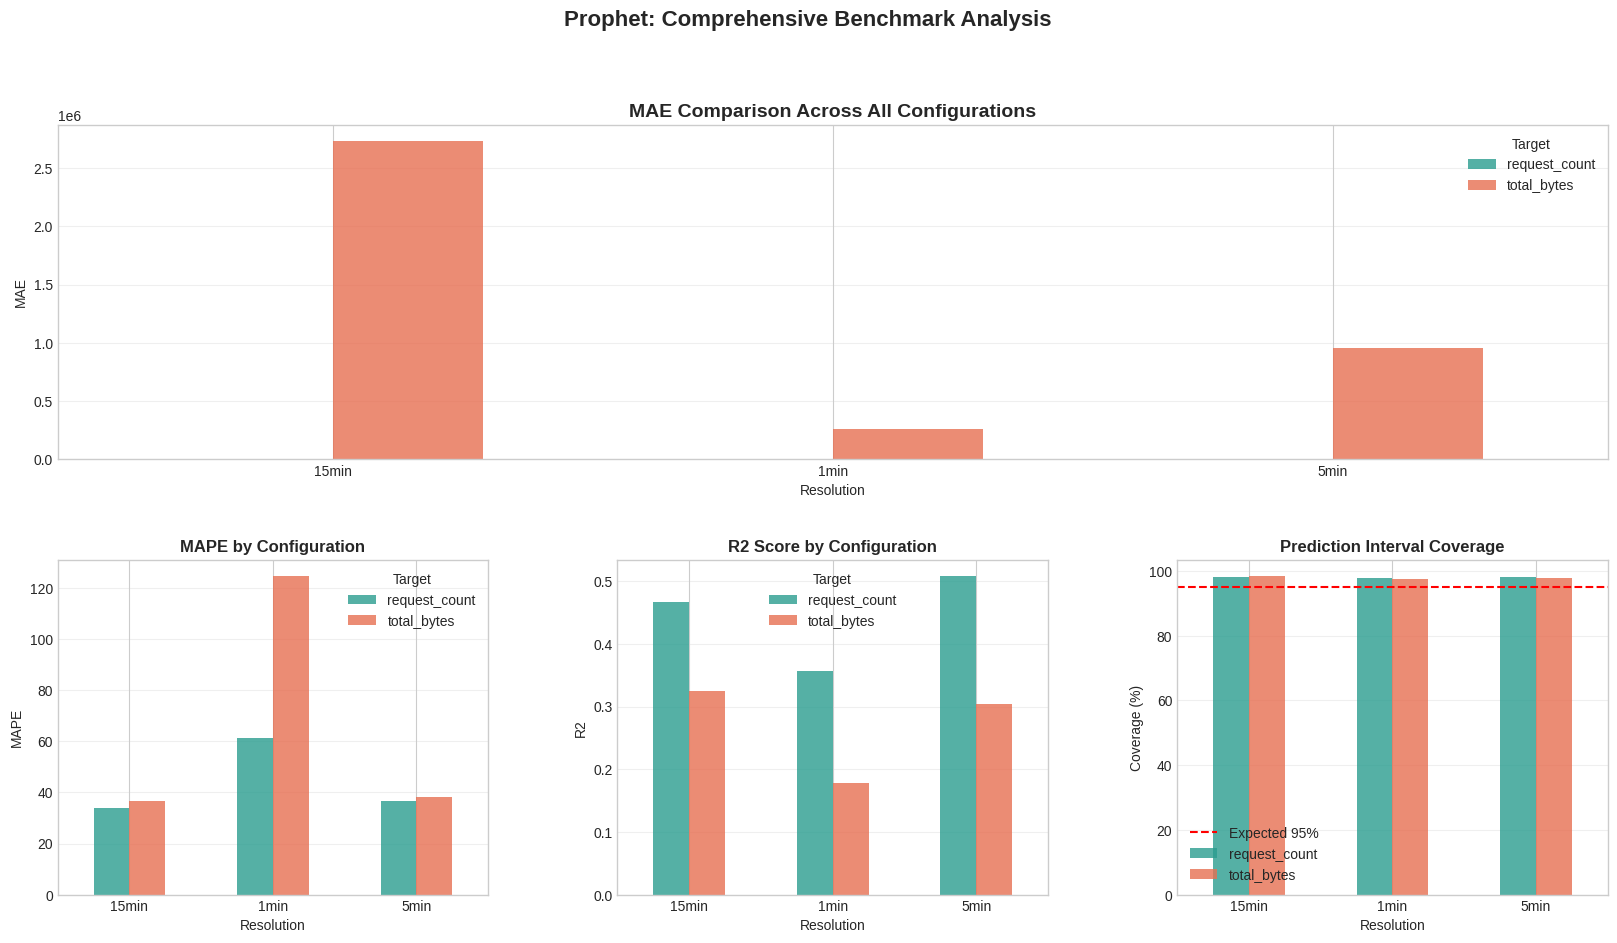

✓ Visualizations saved: /kaggle/working//FINAL_BENCHMARK/benchmark_visualizations.png


In [25]:
# ===========================
# CELL 8: BENCHMARK VISUALIZATIONS
# ===========================

print("\n[CREATING BENCHMARK VISUALIZATIONS]\n")

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. MAE by Resolution and Target
ax1 = fig.add_subplot(gs[0, :])
pivot_mae = benchmark_df.pivot_table(values='mae', index='resolution', columns='target')
pivot_mae.plot(kind='bar', ax=ax1, color=['#2a9d8f', '#e76f51'], alpha=0.8, width=0.6)
ax1.set_title('MAE Comparison Across All Configurations', fontweight='bold', fontsize=14)
ax1.set_ylabel('MAE')
ax1.set_xlabel('Resolution')
ax1.legend(title='Target')
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# 2. MAPE Comparison
ax2 = fig.add_subplot(gs[1, 0])
pivot_mape = benchmark_df.pivot_table(values='mape', index='resolution', columns='target')
pivot_mape.plot(kind='bar', ax=ax2, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax2.set_title('MAPE by Configuration', fontweight='bold', fontsize=12)
ax2.set_ylabel('MAPE')
ax2.set_xlabel('Resolution')
ax2.legend(title='Target')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# 3. R² Comparison
ax3 = fig.add_subplot(gs[1, 1])
pivot_r2 = benchmark_df.pivot_table(values='r2', index='resolution', columns='target')
pivot_r2.plot(kind='bar', ax=ax3, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax3.set_title('R2 Score by Configuration', fontweight='bold', fontsize=12)
ax3.set_ylabel('R2')
ax3.set_xlabel('Resolution')
ax3.legend(title='Target')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 4. Interval Coverage
ax4 = fig.add_subplot(gs[1, 2])
pivot_coverage = benchmark_df.pivot_table(values='interval_coverage', index='resolution', columns='target')
pivot_coverage.plot(kind='bar', ax=ax4, color=['#2a9d8f', '#e76f51'], alpha=0.8)
ax4.axhline(y=95, color='red', linestyle='--', label='Expected 95%')
ax4.set_title('Prediction Interval Coverage', fontweight='bold', fontsize=12)
ax4.set_ylabel('Coverage (%)')
ax4.set_xlabel('Resolution')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

plt.suptitle('Prophet: Comprehensive Benchmark Analysis', 
            fontsize=16, fontweight='bold', y=0.995)

viz_file = f"{benchmark_dir}/benchmark_visualizations.png"
plt.savefig(viz_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualizations saved: {viz_file}")

In [27]:
# ===========================
# CELL 10: SUMMARY & NEXT STEPS
# ===========================

print("\n" + "="*80)
print("🎉 AUTOMATED PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n📊 SUMMARY:")
print(f"  Total configurations trained: {len(all_results)}")
print(f"  Total time: {total_elapsed/60:.1f} minutes")
print(f"  Average time per config: {total_elapsed/len(all_results):.1f} seconds")

print(f"\n📁 RESULTS LOCATION:")
print(f"  Main directory: {RESULTS_BASE_DIR}")
print(f"  Benchmark: {benchmark_dir}")

print(f"\n🏆 BEST CONFIGURATION:")
print(f"  {overall_best['resolution']} | {overall_best['target']}")
print(f"  MAE: {overall_best['mae']:.2f}, MAPE: {overall_best['mape']:.2f}%, R²: {overall_best['r2']:.4f}")

print(f"\n📈 TOP 3 PERFORMERS (by MAE):")
top_3 = benchmark_df.nsmallest(3, 'mae')[['resolution', 'target', 'mae','mse','rmse', 'mape']]
for idx, row in top_3.iterrows():
    print(f"  {row['resolution']:5s} | {row['target']:15s}| MSE: {row['mse']:6.2f} | MAE: {row['mae']:6.2f} | MAPE: {row['mape']:5.2f}%")

print(f"\n💡 NEXT STEPS:")
print(f"  1. Review the final_report.txt in {benchmark_dir}")
print(f"  2. Check benchmark_visualizations.png for visual analysis")
print(f"  3. Use best_parameters.csv from best configuration for production")
print(f"  4. Implement Prophet forecasting in autoscaling system")
print(f"  5. Set up weekly retraining schedule")

print(f"\n" + "="*80)
print("All results have been saved to Google Drive!")
print("="*80)


🎉 AUTOMATED PIPELINE COMPLETED SUCCESSFULLY!

📊 SUMMARY:
  Total configurations trained: 6
  Total time: 16.0 minutes
  Average time per config: 159.6 seconds

📁 RESULTS LOCATION:
  Main directory: /kaggle/working/
  Benchmark: /kaggle/working//FINAL_BENCHMARK

🏆 BEST CONFIGURATION:
  1min | request_count
  MAE: 15.91, MAPE: 61.38%, R²: 0.3562

📈 TOP 3 PERFORMERS (by MAE):
  1min  | request_count  | MSE: 468.75 | MAE:  15.91 | MAPE: 61.38%
  5min  | request_count  | MSE: 7359.10 | MAE:  59.52 | MAPE: 36.67%
  15min | request_count  | MSE: 67020.44 | MAE: 189.04 | MAPE: 33.96%

💡 NEXT STEPS:
  1. Review the final_report.txt in /kaggle/working//FINAL_BENCHMARK
  2. Check benchmark_visualizations.png for visual analysis
  3. Use best_parameters.csv from best configuration for production
  4. Implement Prophet forecasting in autoscaling system
  5. Set up weekly retraining schedule

All results have been saved to Google Drive!
